<a href="https://colab.research.google.com/github/sahupra1357/LLMAgents/blob/main/Gorq_VisionFunctionCalling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/groq/groq-api-cookbook/blob/main/tutorials/multimodal-image-processing/llama-3.2-vision-function-calling.ipynb

In [1]:
import os
from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["NINJA_API_KEY"] = userdata.get('NINJA_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
ninja_api_key = os.getenv('NINJA_API_KEY')

In [2]:
from openai import OpenAI

client_openai = OpenAI()
gpt4o="gpt-4o"

In [3]:
!pip install groq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 3.1 MB/s eta 0:00:00


In [4]:
from groq import Groq
import base64
from IPython.display import Image
import os
import requests
import json

In [5]:
client = Groq()
model = 'llama-3.2-11b-vision-preview'

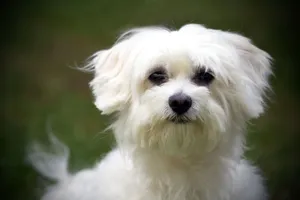

In [6]:
# Load and display the image
image_path = 'images/maltese.png'
Image(image_path)

In [7]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

base64_image = encode_image(image_path)

In [8]:
user_prompt = 'What is the dog breed in this image?'
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    },
                },
                {"type": "text", "text": user_prompt},
            ],
        }
    ],
    model=model
)

print(chat_completion.choices[0].message.content)

The dog breed in this image appears to be a Maltese.


In [9]:
def get_dog_facts(breed_name):
    # Format the API URL with the specific breed name for the API request
    api_url = 'https://api.api-ninjas.com/v1/dogs?name={}'.format(breed_name)

    # Perform a GET request to the API with the API key in the headers for authentication
    response = requests.get(api_url, headers={'X-Api-Key': ninja_api_key})

    # Check if the response from the server is OK (status code 200)
    if response.status_code == requests.codes.ok:
        # Extract the first dog breed match from the response JSON array
        top_match = response.json()[0] # Multiple top matches may be returned; take the first result
        return top_match
    else:
        # Return an error message with the status code and text if the request was not successful
        return "Error:", response.status_code, response.text

In [10]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_dog_facts",
            "description": "Gets facts about a given dog breed",
            "parameters": {
                "type": "object",
                "properties": {
                    "breed_name": {
                        "type": "string",
                        "description": "The name of the dog breed",
                    }
                },
                "required": ["breed_name"],
            },
        },
    }
]

In [12]:
# Function to call the LLaMA Vision Tool
def llama_vision_tool_call(client, model, base64_image, available_functions):

    chat_completion = client.chat.completions.create(
        # The user message containing the image
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"  # Decode the base64 image
                        },
                    },
                ],
            }
        ],
        model=model,
        tools=tools, # The tools to be used
        tool_choice="auto" # Automatically choose the tool
    )

    response_message = chat_completion.choices[0].message
    print("chat_completion --> ", chat_completion)
    # Get the tool calls from the response message
    tool_calls = response_message.tool_calls

    # Call each available function
    for tool_call in tool_calls:
        # Get the function name from the tool call
        function_name = tool_call.function.name

        # Get the function to call from the available functions dictionary
        function_to_call = available_functions[function_name]

        # Parse the function arguments from the tool call
        function_args = json.loads(tool_call.function.arguments)

        # Call the function with the breed name
        function_response = function_to_call(
            breed_name=function_args.get("breed_name")
        )

    # Return the response from the called function
    return function_response


# Define available functions
available_functions = {
    "get_dog_facts": get_dog_facts,  # Example function to get dog facts
}

In [13]:
dog_breed_json = llama_vision_tool_call(client, model, base64_image, available_functions)
print(dog_breed_json)

chat_completion -->  ChatCompletion(id='chatcmpl-346a69e0-9534-4c77-a515-c8c747eedb0c', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', executed_tools=None, function_call=None, reasoning=None, tool_calls=[ChatCompletionMessageToolCall(id='call_fj5p', function=Function(arguments='{"breed_name": "Maltese"}', name='get_dog_facts'), type='function')]))], created=1743561529, model='llama-3.2-11b-vision-preview', object='chat.completion', system_fingerprint='fp_fa3d3d25b0', usage=CompletionUsage(completion_tokens=22, prompt_tokens=210, total_tokens=232, completion_time=0.031776498, prompt_time=0.014012853, queue_time=0.272583203, total_time=0.045789351), usage_breakdown=UsageBreakdown(models=None), x_groq={'id': 'req_01jqt5v5t0f2nsa5q8eztqx0p5'})
{'image_link': 'https://api-ninjas.com/images/dogs/maltese.jpg', 'good_with_children': 3, 'good_with_other_dogs': 3, 'shedding': 1, 'grooming': 4, 'drooling': 1, 'coat

In [16]:
openai_dog_breed_json = llama_vision_tool_call(client_openai, gpt4o, base64_image, available_functions)
print(openai_dog_breed_json)

chat_completion -->  ChatCompletion(id='chatcmpl-BHiac4J7UWqgUVHnAxwOdatkDHbCe', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='This looks like a Maltese. Would you like to know more about this breed?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1743562678, model='gpt-4o-2024-08-06', object='chat.completion', service_tier='default', system_fingerprint='fp_de57b65c90', usage=CompletionUsage(completion_tokens=19, prompt_tokens=308, total_tokens=327, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))


TypeError: 'NoneType' object is not iterable

In [17]:
def assess_dog_breed(client, model, dog_breed_json):

    user_message = f"""
    Write an assessment of this dog breed given the JSON info provided; below is a description of the fields in the JSON:

    {dog_breed_json}

    Description:

    1. Shedding:
       - Description: How much hair the breed sheds.
       - Possible values: 1 to 5 (where 1 indicates no shedding and 5 indicates maximum shedding).

    2. Barking:
       - Description: How vocal the breed is.
       - Possible values: 1 to 5 (where 1 indicates minimal barking and 5 indicates maximum barking).

    3. Energy:
       - Description: How much energy the breed has.
       - Possible values: 1 to 5 (where 1 indicates low energy and 5 indicates high energy).

    4. Protectiveness:
       - Description: How likely the breed is to alert strangers.
       - Possible values: 1 to 5 (where 1 indicates minimal alerting and 5 indicates maximum alerting).

    5. Trainability:
       - Description: How easy it is to train the breed.
       - Possible values: 1 to 5 (where 1 indicates the breed is very difficult to train and 5 indicates the breed is very easy to train).

    6. Name:
       - Description: The name of the breed.

    7. Min Height:
       - Description: Minimum height in inches.

    8. Max Height:
       - Description: Maximum height in inches.

    9. Min Weight:
       - Description: Minimum weight in pounds.

    10. Max Weight:
       - Description: Maximum weight in pounds.

    11. Min Life Expectancy:
       - Description: Minimum life expectancy in years.

    12. Max Life Expectancy:
       - Description: Maximum life expectancy in years.

    (do not mention the JSON data, just use it to inform your response)
    """

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": user_message
            }
        ],
        model=model
    )

    return chat_completion.choices[0].message.content

In [18]:
dog_breed_assessment = assess_dog_breed(client, model, dog_breed_json)
print(dog_breed_assessment)

**Breed Assessment: Maltese**

The Maltese is a small, gentle, and affectionate dog breed. Here's a comprehensive assessment of its characteristics:

**Temperament and Socialization:**

The Maltese is a good breed for families with children, as it is generally good with kids and gentle in its interactions. However, like any breed, it is essential to socialize the Maltese well, especially when it comes to other dogs and strangers. Its protectiveness rating of 4 out of 5 suggests that it may alert strangers, but it is not overly aggressive.

**Grooming:**

The Maltese requires moderate grooming efforts, with a rating of 4 out of 5. Its low-shedding coat is a significant advantage, making it a suitable choice for people with allergies or who prefer less dog hair. However, regular grooming is still necessary to prevent matting and tangling of its long, silky coat.

**Training and Energy:**

The Maltese has an average trainability rating of 3 out of 5, indicating that it can be trained with

## Image Classification

https://github.com/groq/groq-api-cookbook/blob/main/tutorials/multimodal-image-processing/llama-3.2-image-classification.ipynb

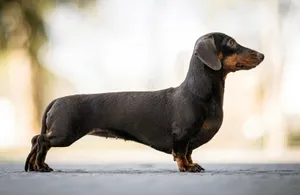

In [19]:
# Load and display the image
image_path = 'images/dachshund.png'
Image(image_path)

In [20]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

base64_image = encode_image(image_path)

In [21]:
user_prompt = 'Tell me about this image'
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    },
                },
                {"type": "text", "text": user_prompt},
            ],
        }
    ],
    model=model
)

In [22]:
print(chat_completion.choices[0].message.content)

The image features a dog in the background, with a blurry and out-of-focus appearance.

The dog is a dachshund, characterized by its distinctive brown and black coat, long and low body, and short legs. Its ears are floppy and hanging down, while its eyes are not visible due to the blurriness of the image. The dachshund is facing to the right on a gray brick road or sidewalk, with trees appearing in the distance.


In [23]:
user_prompt='''
You are an image classification API specializing in dog photos that responds in JSON. What dog breed is shown in this image?
Return in the following JSON format:

{
  "dog_breed": "string (e.g., 'Golden Retriever', 'German Shepherd', 'Mixed')"
}
'''

def image_classification(base64_image, user_prompt):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                        },
                    },
                    {"type": "text", "text": user_prompt},
                ],
            }
        ],
        model=model,
        response_format = {"type": "json_object"}
    )

    return json.loads(chat_completion.choices[0].message.content)

In [24]:
image_classification(base64_image, user_prompt)

{'dog_breed': 'Dachshund'}

In [25]:
user_prompt = '''
Your job is to extract structured data from an image of dogs and output the structured data in JSON.
The JSON schema should strictly be the following:
  {
    "dog_breed": "string (e.g., 'Golden Retriever', 'German Shepherd', 'Mixed')",
    "dog_color": "string (categorical: 'Black', 'White', 'Brown', 'Golden', 'Multiple')",
    "number_of_dogs": "integer (number of dogs in the image)",
    "puppies_present": "boolean (TRUE if there are puppies in the image)",
    "dog_size": "string (categorical: 'Toy', 'Small', 'Medium', 'Large')",
    "is_pet": "boolean (True if the dog is a pet, False if it might be a wild animal like a wolf or coyote)",
    "dog_activity": "string (categorical: 'Sitting', 'Standing', 'Running', 'Playing', 'Sleeping')",
    "background_environment": "string (categorical: 'Indoors', 'Outdoors', 'Park', 'Beach', 'Forest')",
    "dog_accessories": "string (accessories or items the dog is wearing or carrying, e.g., 'Collar', 'Leash', 'Bandana', 'Toy', 'Stick', 'Ball', 'None')"
  }

Use the information from the following dog photo to construct the proper JSON output.
'''

image_json = image_classification(base64_image, user_prompt)
image_json

{'dog_breed': 'Dachshund',
 'dog_color': 'Black and Brown',
 'number_of_dogs': 1,
 'puppies_present': False,
 'dog_size': 'Small',
 'is_pet': True,
 'dog_activity': 'Standing',
 'background_environment': 'Outdoors',
 'dog_accessories': 'Collar'}

Below need images to be uploaded from
https://github.com/groq/groq-api-cookbook/tree/main/tutorials/multimodal-image-processing

In [ ]:
image_folder = 'images/'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_json_list = []

for image_file in sorted(image_files):
    image_path = image_folder + image_file

    # Encode Image
    base64_image = encode_image(image_path)

    # Classify image in JSON mode
    image_json = image_classification(base64_image, user_prompt)

    # Add image file name as a feature
    image_json['image_file'] = image_file

    # Append to image JSON list
    image_json_list.append(image_json)